In [1]:
import json
import os
import types
import zipfile

import numpy
import pandas
import tensorflow as tf

from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models

2024-03-26 16:44:52.928113: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 16:44:52.967700: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 16:44:53.091781: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 16:44:53.092374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 16:44:53.821727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [9]:
segments, labels = [], []
one_hot_encoding = {}
for filename in os.listdir():
    if filename.endswith('.dai'):
        with open(filename) as f:
            project_data = json.load(f, object_hook=lambda d: types.SimpleNamespace(**d))

            print(project_data)

            for file_data in project_data:
                try:
                    sensor_data = pandas.read_csv(file_data.file_name)

                    for session in file_data.sessions:
                        for segment in session.segments:
                            if segment.value not in one_hot_encoding:
                                print(segment.value, len(one_hot_encoding))
                                one_hot_encoding[segment.value] = len(one_hot_encoding)
                            segment_data = sensor_data[segment.start:segment.end + 1].drop(columns=['sequence'])

                            segments.append(segment_data.values.ravel())
                            labels.append(one_hot_encoding[segment.value])
                except FileNotFoundError:
                    pass
max_length = min(len(segment) for segment in segments)
# x = numpy.array([numpy.pad(segment, (0, max_length - len(segment))) for segment in segments]) / 1000
x = numpy.array([segment[:max_length] for segment in segments]) / 1000
y = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, stratify=y)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train = (x_train - numpy.mean(x_train)) / numpy.std(x_train)
# x_test = (x_test - numpy.mean(x_test)) / numpy.std(x_test)

[namespace(file_name='data_V.csv', sessions=[namespace(session_name='Training Session', segments=[namespace(name='Label', value='V', start=59, end=293), namespace(name='Label', value='V', start=385, end=630), namespace(name='Label', value='V', start=762, end=987), namespace(name='Label', value='V', start=1087, end=1305), namespace(name='Label', value='V', start=1446, end=1670), namespace(name='Label', value='V', start=1772, end=2005), namespace(name='Label', value='V', start=2129, end=2350), namespace(name='Label', value='V', start=2441, end=2679), namespace(name='Label', value='V', start=2778, end=2980), namespace(name='Label', value='V', start=3096, end=3304), namespace(name='Label', value='V', start=3417, end=3650), namespace(name='Label', value='V', start=3743, end=3966), namespace(name='Label', value='V', start=4140, end=4360), namespace(name='Label', value='V', start=4504, end=4732), namespace(name='Label', value='V', start=4823, end=5010), namespace(name='Label', value='V', star

In [3]:
x.shape


(51, 546)

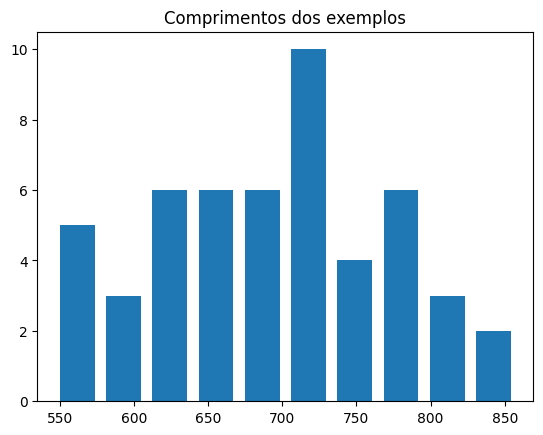

In [4]:
pyplot.title('Comprimentos dos exemplos')
lengths = numpy.array([len(segment) for segment in segments])
pyplot.hist(lengths, rwidth=0.75, bins=10)

pyplot.show()

['Z', 'O', 'V'] [11 14 13]
['Z', 'O', 'V'] [4 4 5]


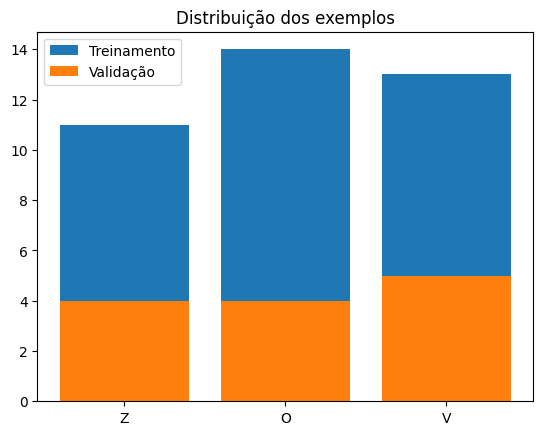

In [5]:
labels = list(one_hot_encoding.keys())

pyplot.title('Distribuição dos exemplos')

height =  numpy.histogram(y_train.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Treinamento')

height =  numpy.histogram(y_test.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Validação')

pyplot.legend()
pyplot.show()

In [8]:

# Defina a arquitetura da rede neural
model = models.Sequential()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(len(one_hot_encoding), activation='softmax'),
])

# Compile o modelo

model.compile(loss='categorical_crossentropy',
              metrics=['acc'])

# Treine o modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 88ms/step - loss: 1.1462 - acc: 0.3684 - val_loss: 1.1450 - val_acc: 0.3077
Epoch 2/100
2/2 [==============================] - 0s 15ms/step - loss: 1.1343 - acc: 0.2895 - val_loss: 0.9573 - val_acc: 0.6154
Epoch 3/100
2/2 [==============================] - 0s 15ms/step - loss: 0.9874 - acc: 0.5000 - val_loss: 0.9301 - val_acc: 0.5385
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 0.9640 - acc: 0.6316 - val_loss: 0.8619 - val_acc: 0.8462
Epoch 5/100
2/2 [==============================] - 0s 17ms/step - loss: 0.8653 - acc: 0.8421 - val_loss: 0.8096 - val_acc: 0.8462
Epoch 6/100
2/2 [==============================] - 0s 16ms/step - loss: 0.8351 - acc: 0.7632 - val_loss: 0.9115 - val_acc: 0.5385
Epoch 7/100
2/2 [==============================] - 0s 16ms/step - loss: 0.8409 - acc: 0.6316 - val_loss: 0.7600 - val_acc: 0.8462
Epoch 8/100
2/2 [==============================] - 0s 15ms/step - loss: 0.7747 - acc: 0.86

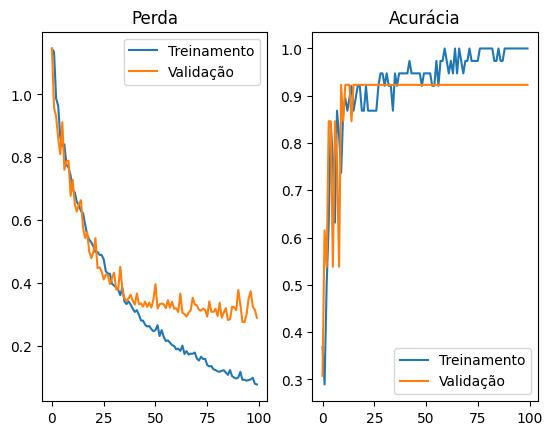

In [9]:
fig, ax = pyplot.subplots(1, 2)

ax[0].set_title('Perda')
ax[0].plot(history.epoch, history.history['loss'], label='Treinamento')
ax[0].plot(history.epoch, history.history['val_loss'], label='Validação')
ax[0].legend()

ax[1].set_title('Acurácia')
ax[1].plot(history.epoch, history.history['acc'], label='Treinamento')
ax[1].plot(history.epoch, history.history['val_acc'], label='Validação')
ax[1].legend()

pyplot.show()

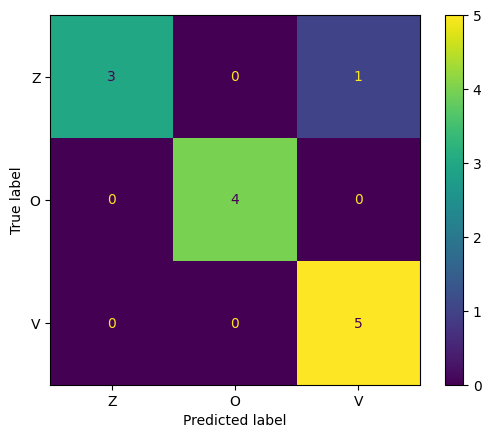

,Z,O,V,accuracy,macro avg,weighted avg
precision,1.000000,1.0,0.833333,0.923077,0.944444,0.935897
recall,0.750000,1.0,1.000000,0.923077,0.916667,0.923077
f1-score,0.857143,1.0,0.909091,0.923077,0.922078,0.921079
support,4.000000,4.0,5.000000,0.923077,13.000000,13.000000


In [10]:
y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
y_true = y_test.argmax(axis=1)

labels = list(one_hot_encoding.keys())
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=None, display_labels=labels)
pyplot.show()

pandas.DataFrame.from_dict(classification_report(y_true, y_pred, target_names=labels, output_dict=True))

In [11]:
def calculate_model_size(model):
    print(model.summary())
    var_sizes = [
            numpy.product(list(map(int, v.shape))) * v.dtype.size
            for v in model.trainable_variables
    ]
    print("Model size:", sum(var_sizes) / 1024, "KB")


calculate_model_size(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 546)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5470      
                                                                 
 dense_4 (Dense)             (None, 3)                 33        
                                                                 
Total params: 5503 (21.50 KB)
Trainable params: 5503 (21.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model size: 21.49609375 KB


In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("model_quantized.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

INFO:tensorflow:Assets written to: /tmp/tmph3966p5m/assets


INFO:tensorflow:Assets written to: /tmp/tmph3966p5m/assets
2024-03-26 16:46:43.669272: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-26 16:46:43.669300: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-26 16:46:43.669515: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph3966p5m
2024-03-26 16:46:43.670074: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-26 16:46:43.670098: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmph3966p5m
2024-03-26 16:46:43.671403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-03-26 16:46:43.671783: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-26 16:46:43.690759: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmp36u1rzad/assets


INFO:tensorflow:Assets written to: /tmp/tmp36u1rzad/assets


Basic model is 24020 bytes
Quantized model is 7712 bytes
Difference is 16308 bytes


2024-03-26 16:46:43.999361: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-26 16:46:43.999380: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-26 16:46:43.999499: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp36u1rzad
2024-03-26 16:46:43.999874: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-26 16:46:43.999881: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp36u1rzad
2024-03-26 16:46:44.000981: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-26 16:46:44.016971: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp36u1rzad
2024-03-26 16:46:44.022243: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 22744 m